In [1]:
from AAE import *
from utils import *

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
X_dim = args['input']['dim']
N = args['input']['hid_size']
z_dim = args['input']['z_dim']
batch_size = args['input']['batch_size']

In [4]:
encoder = AAEEncoder(X_dim, N, z_dim).cuda()
decoder = AAEDecoder(X_dim, N, z_dim).cuda()
loss_function = AAELoss()

In [5]:
mnist_train = datasets.MNIST('./', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = datasets.MNIST('./', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=1,shuffle=True)


torch.manual_seed(10)
discriminator = D_net_gauss(z_dim, N).cuda()
D_gauss = D_net_gauss(z_dim, N).cuda()

# Set optimizators
optim_dec = optim.Adam(encoder.parameters(), lr=0.0006)
optim_enc = optim.Adam(decoder.parameters(), lr=0.0006)
D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=0.0008)

In [6]:
train(encoder, decoder, loss_function, train_loader, discriminator, D_gauss, optim_dec, 
      optim_enc, D_gauss_solver, batch_size=batch_size, X_dim=X_dim, z_dim=z_dim, num_epoch=100)

100 was done


In [10]:
#Evaluation mode so dropout is used well
encoder.eval()
decoder.eval()

List = [[[],[]] for i in range(10)]

In [14]:
encoder = encoder.cpu()
with open('./my_encoder.pk', 'wb') as f:
    torch.save(encoder.state_dict(), f)

In [15]:
encoderr =  AAEEncoder(X_dim, N, z_dim).cuda()
with open('./my_encoder.pk', 'rb') as f:
    encoderr.load_state_dict(torch.load(f))

In [20]:
for i in range(10000):
    '''Taking 400 digits from test set (even though it would be ok to take those sample from the training loader
    since we are inspecting the embedding space)'''
    #Iterate on the dataloader to get 1 item
    pair = iter(test_loader).next()
    
    #get the label and image
    testimg = pair[0]
    label = pair[1]
    testimg = Variable(testimg.view([1,784])).cuda()
    
    #Get the 2D coordinates from the data from the Encoder
    coor = encoderr(testimg)
    coorformat0 = coor[0][0].data.cpu().numpy()
    coorformat1 = coor[0][1].data.cpu().numpy()
    label = label.cpu().numpy()[0]
    
    #Same garbage practices but a copy pasting was really tempting
    #retrieving labels from the and getting coordinates classified by digits
    List[label][0].append(coorformat0)
    List[label][1].append(coorformat1)

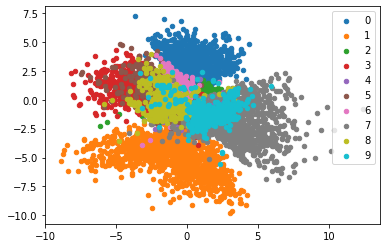

In [21]:
#################################################
############# Saving Latent space ###############
#################################################

plt.clf()
for i in range(10):
    plt.scatter(List[i][0], List[i][1], label=str(i), s=20)
plt.legend(loc='upper right')

plt.savefig('./Adv.png',dpi = 300)
plt.show()